In [1]:
# Step 0. Load libraries and custom functions
# Matrices and datasets ------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
# Deep Learning --------------------------------------------------------
import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Custom functions -----------------------------------------------------
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    param x: sentence as a list of words
    param words: number of words in each sentence
    return: list of fixed length sentences.
    """
    if len(x)>1 and words > 1:
        return [' '.join(x.split(' ')[i:i+10]) for i in range(0,len(x.split(' ')),10)]
    else:
        return x

In [2]:
# Step 1. Load data
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/01_IMDB_Dataset_HuggingFace.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(10)

,review,sentiment
34021,"OK, let me again admit that I haven't seen any...",negative
16800,It was simple and yet so nice. I think the who...,positive
6051,"This utterly dull, senseless, pointless, spiri...",negative
39775,"""The Charge at Feather River"" is a routine Wes...",positive
38885,This group of English pros are a pleasure to w...,positive
12499,"This movie shows me, that americans have no kn...",negative
22089,Payback is the game being played in this drama...,negative
35867,They're showing this on some off-network. It's...,negative
47147,It seems as if in Science Fiction you have thi...,negative
1387,"A terrible amateur movie director (no, not Tod...",negative


In [4]:
# 1.3 Verify if there are duplicates
df_raw['review'].value_counts()

review
Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.                                                                                                                                                                                                         

In [5]:
# 1.3 Preprocess data in order to avoid html tags and show result
df_interim = df_raw.copy()
df_interim['user_review'] = df_interim['review'].str.replace(r'(<.*?>)','',regex=True)
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s+',' ',regex=True)
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s,\s',', ',regex=True)
df_interim['user_review'] = df_interim['user_review'].str.replace(r'\\','',regex=True)
df_interim['label'] = df_interim['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df_interim = df_interim.drop_duplicates()
df_interim = df_interim.drop([44855],axis=0)
#df_interim['reviews'] = df_interim['user_review'].apply(lambda x: sentence_fixed_split(x,2000))
#df_interim = df_interim.explode('reviews')

In [6]:
df = df_interim.drop(['review','sentiment'], axis=1).copy()
df

,label,reviews
0,1,One of the other reviewers has mentioned that ...
0,1,just 1 Oz episode you'll be hooked. They are r...
0,1,as this is exactly what happened with me.The f...
0,1,that struck me about Oz was its brutality and ...
0,1,"scenes of violence, which set in right from th..."
...,...,...
49999,0,McCoy at Yosemite.I would say this movie is no...
49999,0,"a rental, and hardly worth watching, however f..."
49999,0,"Fan who needs to see all the movies, renting this"
49999,0,movie is about the only way you'll see it -


In [7]:
# Step 3. Create a basic data analysis
# 3.1 Describe data
df.describe(include='all')

,label,reviews
count,1.149049e+06,1149049
unique,NaN,1145145
top,NaN,it.
freq,NaN,143
mean,5.059262e-01,NaN
std,4.999651e-01,NaN
min,0.000000e+00,NaN
25%,0.000000e+00,NaN
50%,1.000000e+00,NaN
75%,1.000000e+00,NaN


In [9]:
# 3.2 Get statistics based on the len
df['review_len'] = df['reviews'].str.len()
df['review_len'].describe()

count    1.149049e+06
mean     5.454455e+01
std      1.015836e+01
min      0.000000e+00
25%      4.900000e+01
50%      5.400000e+01
75%      6.000000e+01
max      3.760000e+02
Name: review_len, dtype: float64

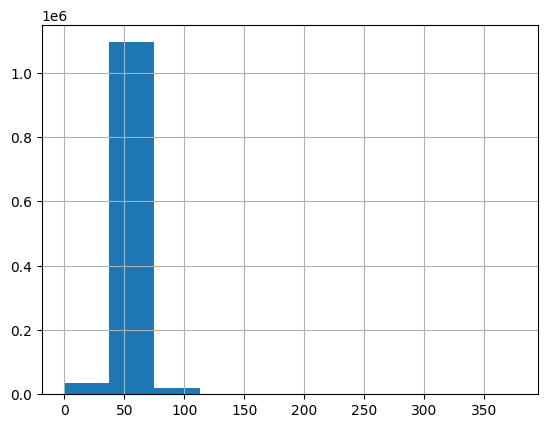

In [10]:
# 3.3 Plot review lenght histogram
df['review_len'].hist()
plt.show()

In [12]:
df['reviews'].str.len().max()

376

In [ ]:
df[df['review_len']==13584].to_dict()

In [ ]:
myfake = pd.DataFrame({'id':[1], 'text':[r"didn\'t get it"]})
myfake

In [ ]:
myfake['text_clean']=myfake['text'].str.replace(r"\\'", "'", regex=True)
myfake

In [ ]:
myfake.to_dict()

In [ ]:
myfake = pd.DataFrame({'text': ["Humpty Dumpty sat on a wall, Humpty Dumpty had a great fall, All the king's horses and all the kings's men couldn't put Humpty together again","Mary had a lamb"],'label':[0,1]})
myfake

In [ ]:
myfake['text'].str.split(' ').str.len().max()

In [ ]:
molist = "Humpty Dumpty sat on a wall, Humpty Dumpty had a great fall, All the king's horses and all the kings's men couldn't put Humpty together again"
[' '.join(molist.split(' ')[i:i+10]) for i in range(0,len(molist.split(' ')),10)]

In [ ]:
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    param x: sentence as a list of words
    param words: number of words in each sentence
    return: list of fixed length sentences.
    """
    if len(x)>1 and words > 1:
        return [' '.join(x.split(' ')[i:i+10]) for i in range(0,len(x.split(' ')),10)]
    else:
        return x

In [ ]:
anew = sentence_fixed_split(molist, 10)

In [ ]:

len(anew)

In [ ]:
myfake['split'] = myfake['text'].apply(lambda x: len(x.split(' ')))
myfake

In [ ]:
# 3.2 Preprocess text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['user_review'])
sequences = tokenizer.texts_to_sequences(df['user_review'])
X = pad_sequences(sequences, maxlen=200)

In [ ]:
# Step 4. Create model and evaluate
# 4.1 Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, df['label'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
# 4.2 Build the model
imputs = keras.Input()